<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Darya-Frolova-folder/Darya%20Frolova%20/%2086_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ЗАГРУЗКА НЕОБХОДИМЫХ БИБЛИОТЕК





In [ ]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

from tensorflow.data import Dataset

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Сегментация картинок
import cv2

# Рисование графиков в ячейках Colab
%matplotlib inline

import random
from PIL import Image
import math
from PIL import Image, ImageEnhance
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

#Задание гиперпараметров модели

In [ ]:
#Задание гиперпараметров

TRAINING_DATA       = '/content/iris_train'    # Папка для обучающего набора данных
TEST_DATA           = '/content/iris_test'     # Папка для тестового набора данных

TEST_SPLIT          = 0.2                      # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                      # Доля проверочной выборки в обучающем наборе
IMG_WIDTH           = 192                      # Ширина изображения для нейросети
IMG_HEIGHT          = 144                      # Высота изображения для нейросети
IMG_CHANNELS        = 3                        # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 2                        # Пределы поворота
WIDTH_SHIFT_RANGE   = 5                        # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 5                        # Пределы сдвига по вертикали
BRIGHTNESS_RANGE    = (0.7, 1.3)               # Пределы изменения яркости
HORIZONTAL_FLIP     = True                     # Горизонтальное отражение разрешено


EPOCHS              = 120                      # Число эпох обучения
BATCH_SIZE          = 32                       # Размер батча для обучения модели
OPTIMIZER           = Adam(0.00001)            # Оптимизатор


#ЗАГРУЗКА ДАТАСЕТА И ПОДГОТОВКА ДАННЫХ


In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://drive.google.com/uc?id=1RbG7rr_M0DFKEelNVLZyY1tvF4hIWxLM', None, quiet=True)

'DATASET_1.zip'

In [ ]:
# Очистка данных от прошлого запуска
!rm -rf {TRAINING_DATA} {TEST_PATH}
!rm -rf `find -type d -name .ipynb_checkpoints`
# Разархивация датасета в директорию данных
!unzip -qo "DATASET_1.zip" -d {TRAINING_DATA}

**Определяем список классов и их число:**

In [ ]:
#Задаем список классов из списка папок
CLASS_LIST = sorted(os.listdir(TRAINING_DATA)) # Определение списка имен классов
CLASS_COUNT = len(CLASS_LIST)  # Определение количества классов
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}') # Проверка результата

Количество классов: 64, метки классов: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064']


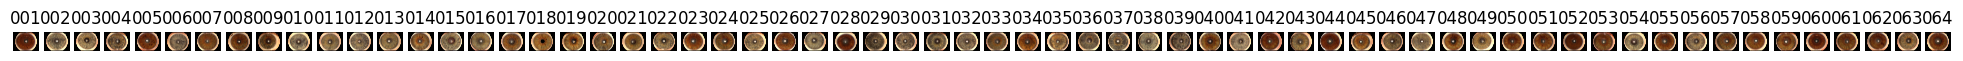

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    class_path = f'{TRAINING_DATA}/{CLASS_LIST[i]}'
    # Выбор случайного фото из i-го класса
    img_path = class_path +'/'+random.choice(os.listdir(class_path))
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных
os.mkdir(TEST_DATA)
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAINING_DATA}/{class_name}'           # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_DATA}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} фото, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса 001: 6 фото, для теста выделено файлов: 1
Размер класса 002: 6 фото, для теста выделено файлов: 1
Размер класса 003: 6 фото, для теста выделено файлов: 1
Размер класса 004: 6 фото, для теста выделено файлов: 1
Размер класса 005: 6 фото, для теста выделено файлов: 1
Размер класса 006: 6 фото, для теста выделено файлов: 1
Размер класса 007: 6 фото, для теста выделено файлов: 1
Размер класса 008: 6 фото, для теста выделено файлов: 1
Размер класса 009: 6 фото, для теста выделено файлов: 1
Размер класса 010: 6 фото, для теста выделено файлов: 1
Размер класса 011: 6 фото, для теста выделено файлов: 1
Размер класса 012: 6 фото, для теста выделено файлов: 1
Размер класса 013: 6 фото, для теста выделено файлов: 1
Размер класса 014: 6 фото, для теста выделено файлов: 1
Размер класса 015: 6 фото, для теста выделено файлов: 1
Размер класса 016: 6 фото, для теста выделено файлов: 1
Размер класса 017: 6 фото, для теста выделено файлов: 1
Размер класса 018: 6 фото, для теста выделено фа

#Аугментация и формирование выборок

In [ ]:
# Генераторы изображений
# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT

train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

In [ ]:
# Изображения для тестовой выборки остаются в прежнем виде, только проводим нормализацию:
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )


In [ ]:
# Создание обучающей выборки из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Создание проверочной выборки из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAINING_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 256 images belonging to 64 classes.
Found 64 images belonging to 64 classes.
Found 64 images belonging to 64 classes.


In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (32, 144, 192, 3), (32, 64), батчей: 8
Формы данных   проверочной выборки: (32, 144, 192, 3), (32, 64), батчей: 2
Формы данных      тестовой выборки: (64, 144, 192, 3), (64, 64), батчей: 1

Метки классов тренировочной выборки: {'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29, '031': 30, '032': 31, '033': 32, '034': 33, '035': 34, '036': 35, '037': 36, '038': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '051': 50, '052': 51, '053': 52, '054': 53, '055': 54, '056': 55, '057': 56, '058': 57, '059': 58, '060': 59, '061': 60, '062': 61, '063': 62, '064': 63}
Метки классов   проверочной выборки: {'001

#ПРОВЕРКА РАБОТЫ ГЕНЕРАТОРОВ ВЫБОРОК

In [ ]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 6),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

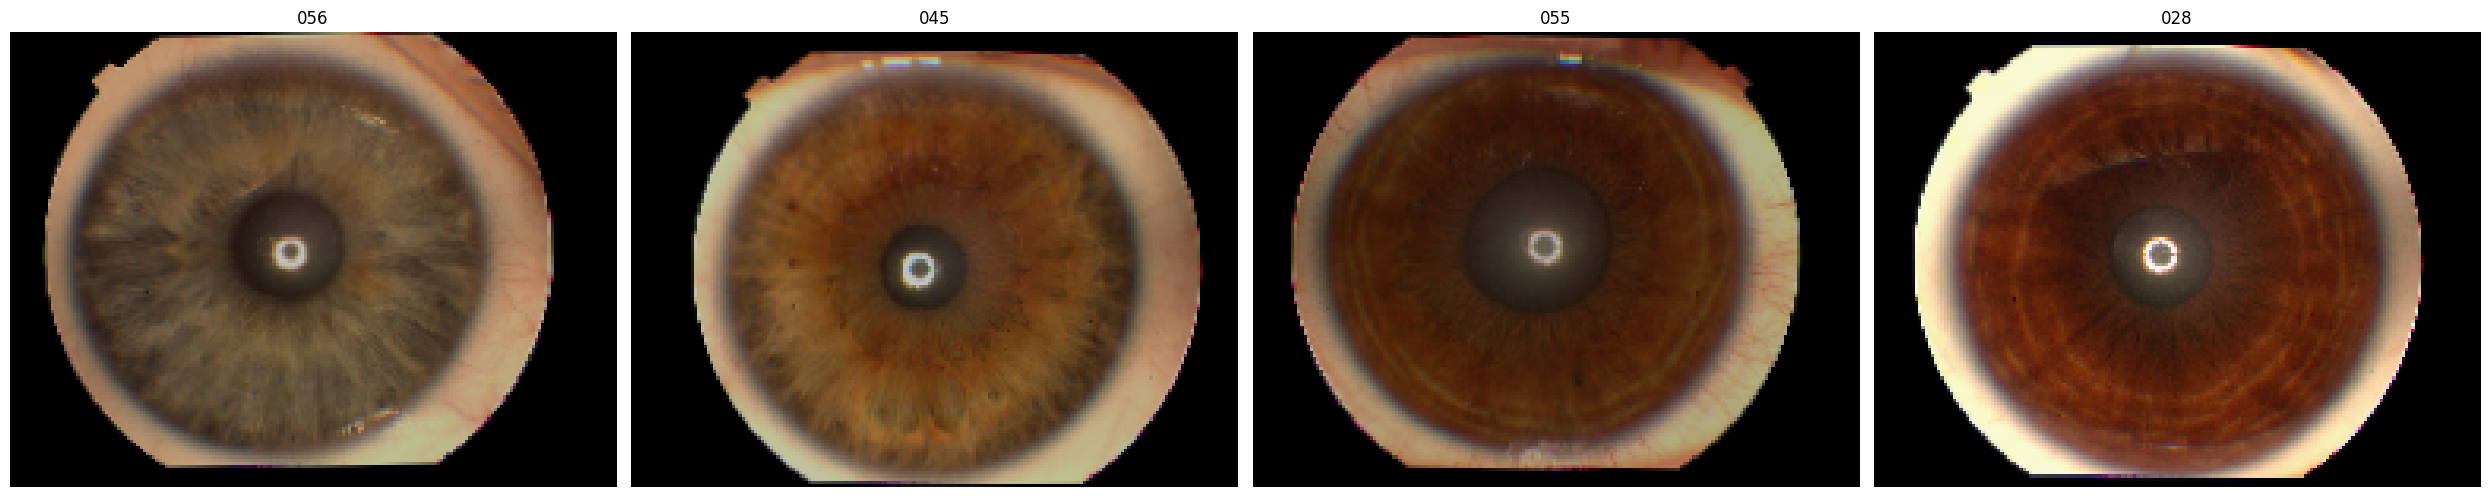

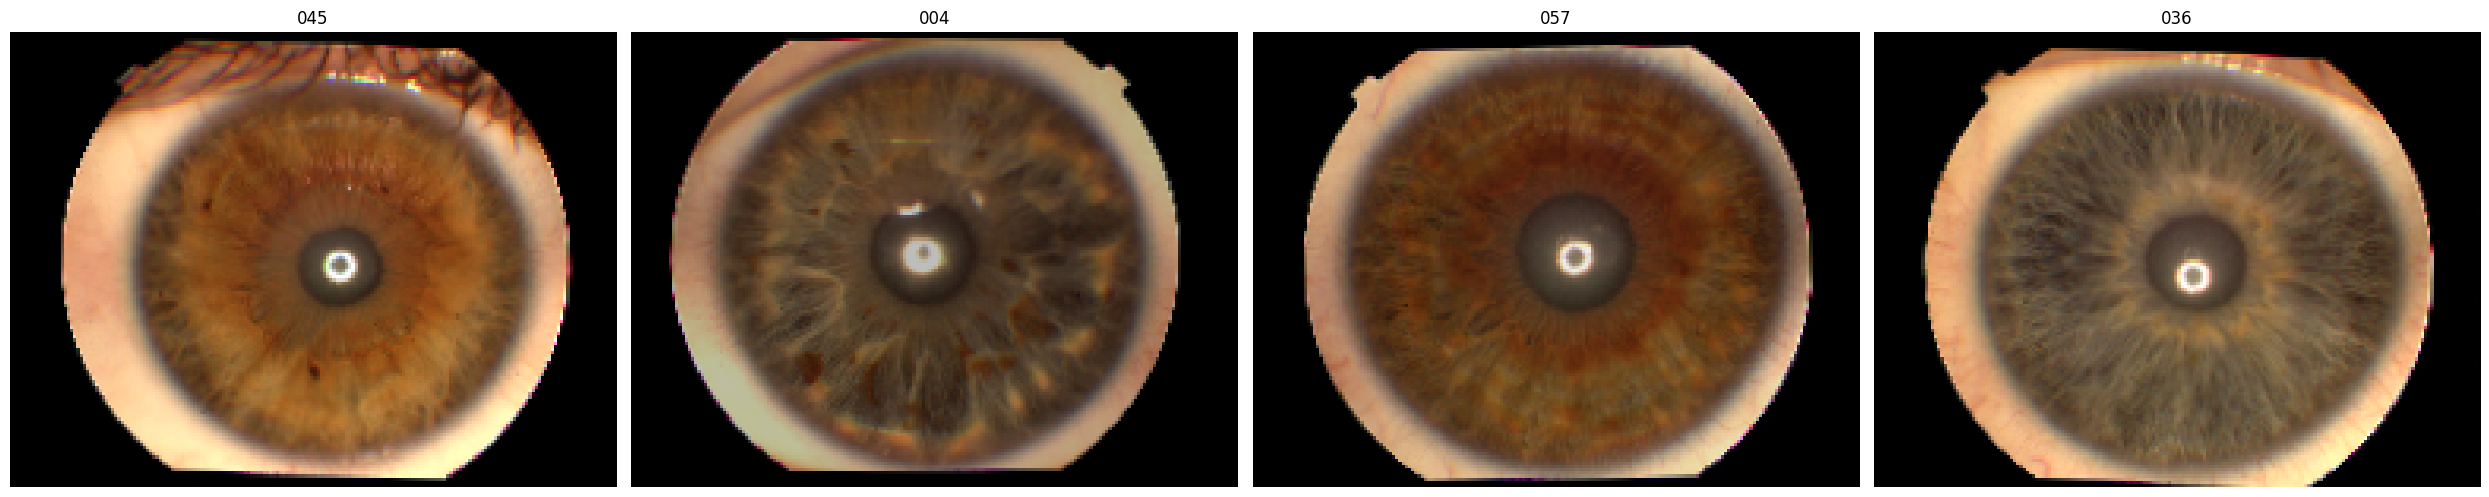

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0], range(8), columns = 4)

In [ ]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

#Создание и обучение модели нейронной сети

#СОЗДАНИЕ СЕРВИСНЫХ ФУНКЦИЙ

In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения
def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
# Функция вывода результатов оценки модели на заданных данных
def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

#Архитектура модели нейронной сети

In [ ]:
# Создание последовательной модели
model = Sequential()

# Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model.add(BatchNormalization())

# Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Четвертый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

# Пятый сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

# Слой преобразования многомерных данных в одномерные
model.add(Flatten())

# Промежуточный полносвязный слой
model.add(Dense(512, activation='relu'))


# Промежуточный полносвязный слой
model.add(Dense(1024, activation='relu'))


# Выходной полносвязный слой с количеством нейронов по количесту классов
model.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 192, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 144, 192, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 192, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 64, 64)       2

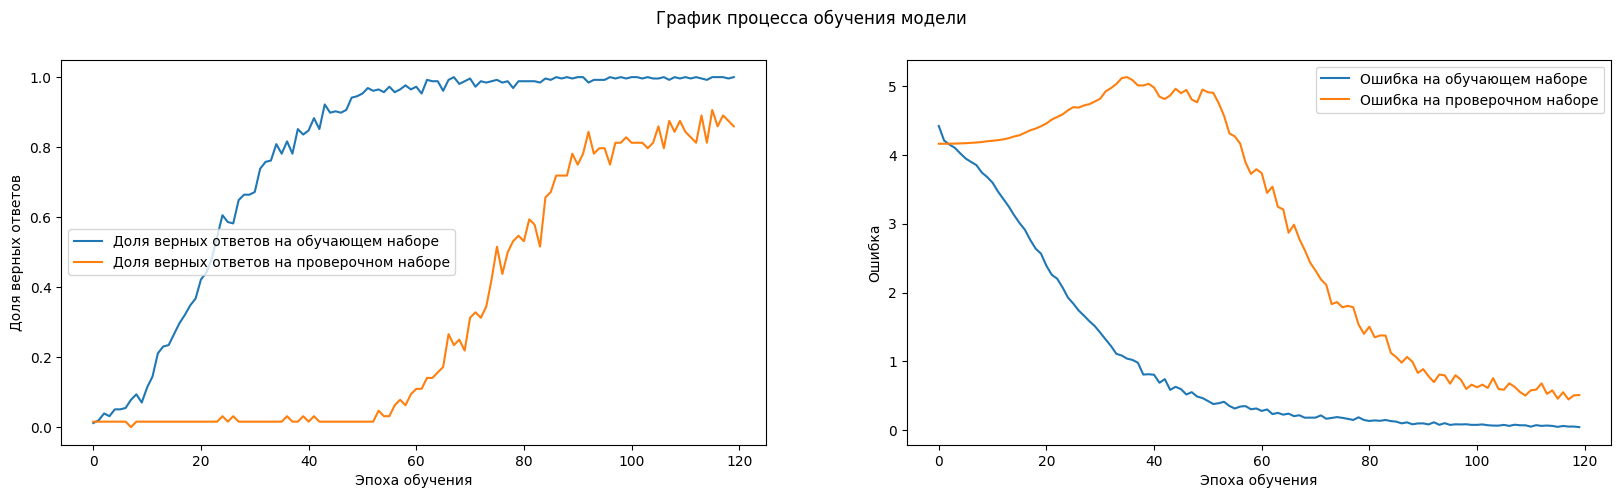

2/2 [==============================] - 0s 21ms/step


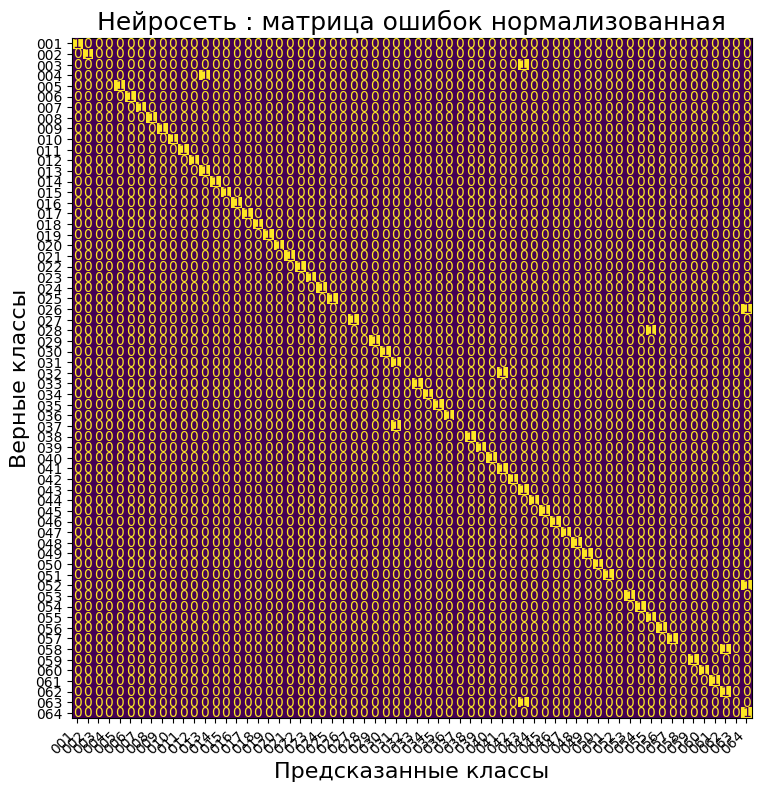

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: 001                  100% сеть отнесла к классу 001                  - ВЕРНО :-)
Класс: 002                  100% сеть отнесла к классу 002                  - ВЕРНО :-)
Класс: 003                  100% сеть отнесла к классу 043                  - НЕВЕРНО :-(
Класс: 004                  100% сеть отнесла к классу 013                  - НЕВЕРНО :-(
Класс: 005                  100% сеть отнесла к классу 005                  - ВЕРНО :-)
Класс: 006                  100% сеть отнесла к классу 006                  - ВЕРНО :-)
Класс: 007                  100% сеть отнесла к классу 007                  - ВЕРНО :-)
Класс: 008                  100% сеть отнесла к классу 008                  - ВЕРНО :-)
Класс: 009                  100% сеть отнесла к классу 009                  - ВЕРНО :-)
Класс: 010                  100% сеть отнесла к классу 010                  - ВЕРНО :-)
Кла

In [ ]:
# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         )